In [7]:
from torch_geometric.datasets import Planetoid, MNISTSuperpixels
from torchvision.datasets import MNIST
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv, SAGEConv
from torch_geometric.data import NeighborSampler
import wandb
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt
import numpy as np
from utils import get_graph_from_image 
from torch_geometric.data import Data

In [8]:
print("Reading dataset")
dataset = MNIST("data/mnist", download=True)

Reading dataset


60000
(60000, 28, 28, 1)


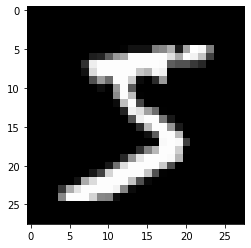

In [9]:
imgs = dataset.data.unsqueeze(-1).numpy().astype(np.float64)
print(len(imgs))
print(imgs.shape)


first_image = imgs[0]
plt.imshow(first_image, cmap='gray')
plt.show()

C:\Users\Ukasz\Anaconda3\envs\gdl\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


torch.Size([2, 472])
torch.Size([77, 3])
77
Data(edge_index=[2, 472], x=[77, 3])


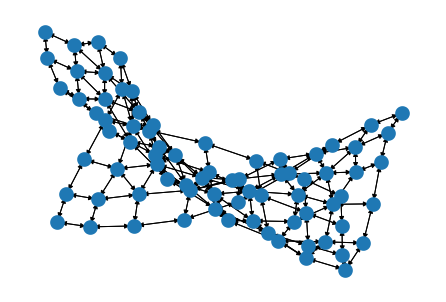

In [87]:
# dataset = Planetoid(root = '../data/cora', name='Cora')
# dataset = MNISTSuperpixels(root = '../data/mnist')

labels = dataset.targets.numpy()

x, edge_index = get_graph_from_image(first_image)

x = torch.tensor(x, dtype=torch.float)
edge_index = torch.tensor(edges, dtype=torch.long)

print(edge_index.shape)
print(x.shape)

data = Data(x=x, edge_index=edge_index)
print(data.num_nodes)
print(data)


G = to_networkx(data, node_attrs=['x'])
nx.draw(G, cmap=plt.get_cmap('Set1'), node_size=75, linewidths=6)
plt.show()



In [ ]:
# print("Processing images into graphs...", end="")
# ptime = time.time()
# with multiprocessing.Pool() as p:
#     graphs = np.array(p.map(util.get_graph_from_image, imgs))
# del imgs
# ptime = time.time() - ptime
# print(" Took {ptime}s".format(ptime=ptime))



In [ ]:
# print(len(dataset))
# print(dataset.num_classes)
# print(dataset.num_node_features)
# print(dataset.num_edge_features)
# print(dataset[0])
# print(dataset[0].is_directed())
# print(dataset[0]['x'])
# print(dataset[0]['train_mask'])

(256, 256, 3)


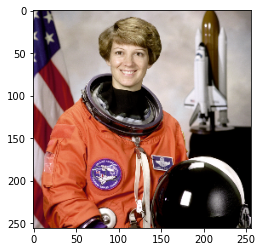

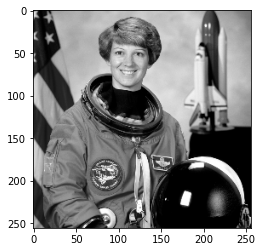

SLIC number of segments: 78


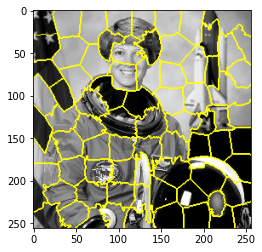

In [62]:
from skimage.segmentation import slic, mark_boundaries
from skimage.data import astronaut
from skimage.util import img_as_float
from skimage.color import gray2rgb, rgb2gray


img = img_as_float(astronaut()[::2, ::2])
print(img.shape)
plt.imshow(img)
plt.show()

img = rgb2gray(img)
img = gray2rgb(img)
plt.imshow(img)
plt.show()

segments = slic(img, n_segments=75, slic_zero=True)

print(f"SLIC number of segments: {len(np.unique(segments))}")

plt.imshow(mark_boundaries(img, segments))
plt.show()

(28, 28, 1)


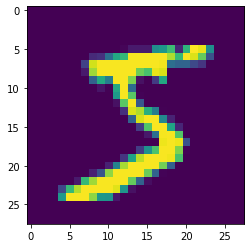

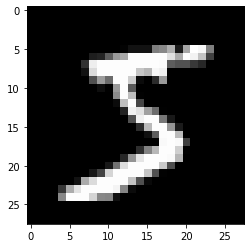

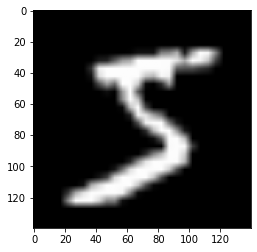

SLIC number of segments: 49


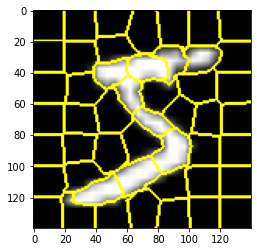

In [58]:
from skimage.segmentation import slic, mark_boundaries
from skimage.data import astronaut
from skimage.util import img_as_float
from skimage.color import gray2rgb
from skimage.transform import rescale

plt.imshow(first_image)
print(first_image.shape)
plt.show()

img = first_image.reshape((28, 28)) / 255

img_rgb = gray2rgb(img)
plt.imshow(img_rgb)
plt.show()

img_rescaled = rescale(img, 5.0, anti_aliasing=False)
img_rescaled = gray2rgb(img_rescaled)
plt.imshow(img_rescaled)
plt.show()


segments = slic(img_rescaled, n_segments=50, slic_zero=True)

print(f"SLIC number of segments: {len(np.unique(segments))}")

plt.imshow(mark_boundaries(img_rescaled, segments))
plt.show()

In [66]:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)
print(edge_index.shape)
print(x.shape)


data = Data(x=x, edge_index=edge_index)
print(data)
print(data.num_nodes)

torch.Size([2, 4])
torch.Size([3, 1])
Data(edge_index=[2, 4], x=[3, 1])
3


In [32]:
dataset = Planetoid(root = 'data/cora', name='Cora')
cora = dataset [0]
print(cora)
# coragraph = to_networkx(cora)
# node_labels = cora.y[list(coragraph.nodes)].numpy()

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])


In [ ]:

# plt.figure(1,figsize=(14,12)) 
# nx.draw(coragraph, cmap=plt.get_cmap('Set1'),node_color = node_labels,node_size=75,linewidths=6)
# plt.show()

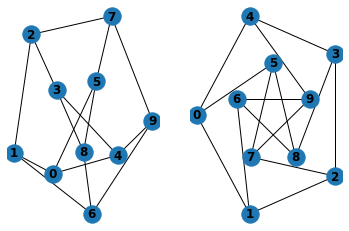

In [11]:
G = nx.petersen_graph()
plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')
# print(coragraph.nodes)

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Net, self).__init__()
        self.conv1 = ChebConv(in_channels, 32, K=2)
        self.conv2 = ChebConv(32, out_channels, K=2)
        
        self.conv1 = SAGEConv(in_channels, 32)
        self.conv2 = SAGEConv(32, out_channels)
        
#         self.conv1 = GCNConv(in_channels, 32)
#         self.conv2 = GCNConv(32, out_channels)
        
    def forward(self, x, edge_index):
#         x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
model = Net(dataset.num_node_features, dataset.num_classes)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
model.to(device)

data = dataset[0]

x = data.x.to(device)
y = data.y.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:

train_loader = NeighborSampler(data.edge_index, node_idx=data.train_mask,
                               sizes=[25, 10], batch_size=1024, shuffle=True,
                               num_workers=12)

In [ ]:
@torch.no_grad()
def test():
    model.eval()

    out = model(x)

    y_true = y.cpu().unsqueeze(-1)
    y_pred = out.argmax(dim=-1, keepdim=True)

    results = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        results += [int(y_pred[mask].eq(y_true[mask]).sum()) / int(mask.sum())]

    return results

In [ ]:
# evaluate()

In [ ]:
model.train()
for i in range(5):
    
    for batch_size, n_id, adjs in train_loader:
        
        optimizer.zero_grad()

        out = model(x[n_id], adjs)
        
        loss = F.nll_loss(out, y[n_id[:batch_size]])
    
        print(loss)
        
        loss.backward()
        optimizer.step()
        
#     print(loss)
#     print(out[0])

In [ ]:
evaluate()